### Import Bulian library and dependencies

In [57]:
sys.path.insert(1,r'F:\Users\Kaggle\bulian')

In [58]:
import os,sys,torch
import pandas as pd
from bulian.synthesizers import TwinSynthesizer,PrivateTwinSynthesizer
from bulian.metrics import *
from bulian.metrics.reports import *
from bulian.metrics import compute_metrics
from bulian.metrics.single_table import SingleTableMetric
from bulian.metrics.single_table import *

In [59]:
import warnings
warnings.filterwarnings('ignore')

### Read raw CSV data

In [60]:
churn = pd.read_csv(r"F:\Users\Kaggle\bulian\examples\csv\Churn.csv")

In [61]:
churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Define column types for ingestion by Bulian models

In [62]:
discrete_columns = [
   'Geography',
   'Gender',
   'HasCrCard',
   'IsActiveMember',
   'Exited'
]

target = 'Exited'

numeric_features = [i for i in churn.columns if i not in discrete_columns]

### Check if GPU is available

In [63]:
print(torch.cuda.is_available(),torch.cuda.current_device(),torch.cuda.get_device_name(0))

True 0 NVIDIA GeForce RTX 3090


In [64]:
!nvidia-smi

Thu Jun 16 16:04:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.79       Driver Version: 511.79       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   52C    P8    27W / 370W |    770MiB / 24576MiB |     19%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

###### 

### Check data statitics

In [65]:
churn.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [66]:
churn['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In [67]:
churn.shape

(10000, 11)

### Build a Bulian.ai synthetic data model to boost class imbalance in churn dataset


In [68]:
synth = TwinSynthesizer(batch_size=200)

In [69]:
synth.fit(data=churn,epochs=100,discrete_columns=discrete_columns)

Epoch: [0]  [ 0/49]  eta: 0:00:01  loss_g: 0.8041 (0.8041)  loss_d: 0.0780 (0.0780)  loss: 0.8820 (0.8820)  time: 0.0312  data: 0.0000  max mem: 0
Epoch: [0]  [49/49]  eta: 0:00:00  loss_g: 0.1277 (0.3849)  loss_d: 0.0200 (0.0055)  loss: 0.1579 (0.3903)  time: 0.0410  data: 0.0000  max mem: 0
Epoch: [0] Total time: 0:00:01
Epoch: [1]  [ 0/49]  eta: 0:00:01  loss_g: 0.2357 (0.2357)  loss_d: -0.0952 (-0.0952)  loss: 0.1405 (0.1405)  time: 0.0380  data: 0.0000  max mem: 0
Epoch: [1]  [49/49]  eta: 0:00:00  loss_g: -0.0255 (0.0127)  loss_d: -0.0328 (-0.0030)  loss: -0.0895 (0.0098)  time: 0.0407  data: 0.0000  max mem: 0
Epoch: [1] Total time: 0:00:01
Epoch: [2]  [ 0/49]  eta: 0:00:02  loss_g: -0.3898 (-0.3898)  loss_d: -0.0120 (-0.0120)  loss: -0.4018 (-0.4018)  time: 0.0420  data: 0.0000  max mem: 0
Epoch: [2]  [49/49]  eta: 0:00:00  loss_g: -0.3948 (-0.3250)  loss_d: 0.0194 (0.0453)  loss: -0.3732 (-0.2797)  time: 0.0391  data: 0.0000  max mem: 0
Epoch: [2] Total time: 0:00:01
Epoch: [3

### Sample 5000 new synthetic rows 

In [70]:
sample = synth.sample(5000)

### Check metrics for newly created synthetic data

In [71]:
metrics = SingleTableMetric.get_subclasses()
compute_metrics(metrics,churn, sample)

,metric,name,raw_score,normalized_score,min_value,max_value,goal,MetricType,error
0,BNLogLikelihood,BayesianNetwork Log Likelihood,NaN,NaN,-inf,0.0,MAXIMIZE,Likelihood Metric,Please install pomegranate with `pip install p...
1,LogisticDetection,LogisticRegression Detection,0.501516,0.501516,0.0,1.0,MAXIMIZE,Real vs Synthetic Dectection Metric,None
2,SVCDetection,SVC Detection,0.435596,0.435596,0.0,1.0,MAXIMIZE,Real vs Synthetic Dectection Metric,None
3,BinaryDecisionTreeClassifier,None,NaN,NaN,0.0,1.0,MAXIMIZE,ML Efficacy Metric: R-Sq or F1,`target` must be passed either directly or ins...
4,BinaryAdaBoostClassifier,None,NaN,NaN,0.0,1.0,MAXIMIZE,ML Efficacy Metric: R-Sq or F1,`target` must be passed either directly or ins...
5,BinaryLogisticRegression,None,NaN,NaN,0.0,1.0,MAXIMIZE,ML Efficacy Metric: R-Sq or F1,`target` must be passed either directly or ins...
6,BinaryMLPClassifier,None,NaN,NaN,0.0,1.0,MAXIMIZE,ML Efficacy Metric: R-Sq or F1,`target` must be passed either directly or ins...
7,MulticlassDecisionTreeClassifier,None,NaN,NaN,0.0,1.0,MAXIMIZE,ML Efficacy Metric: R-Sq or F1,`target` must be passed either directly or ins...
8,MulticlassMLPClassifier,None,NaN,NaN,0.0,1.0,MAXIMIZE,ML Efficacy Metric: R-Sq or F1,`target` must be passed either directly or ins...
9,LinearRegression,None,NaN,NaN,-inf,1.0,MAXIMIZE,ML Efficacy Metric: R-Sq or F1,`target` must be passed either directly or ins...


#### Report with ML efficacy metrics, as that is the key consideration in this case

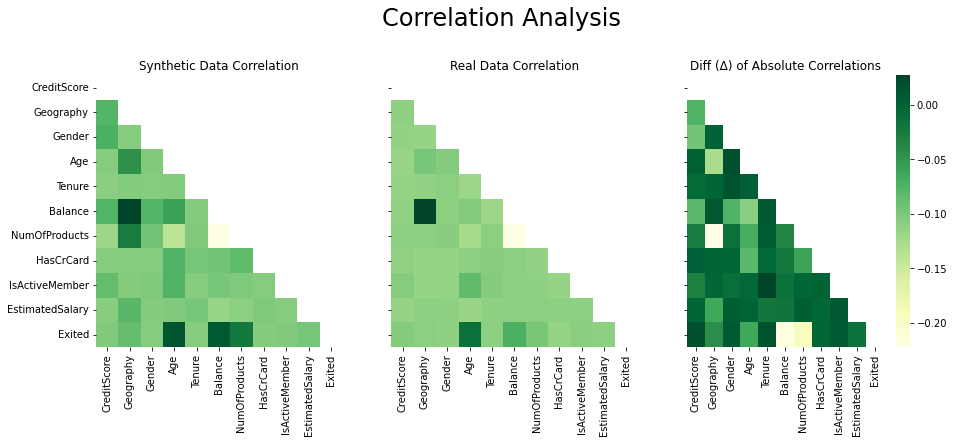

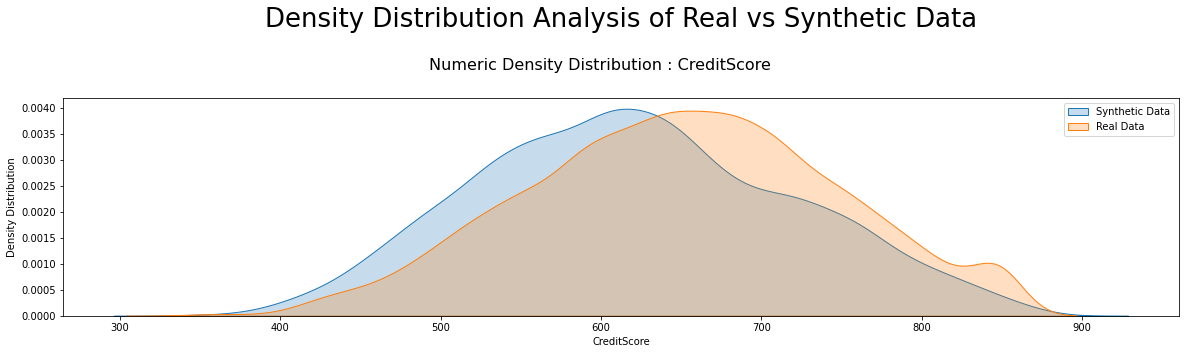

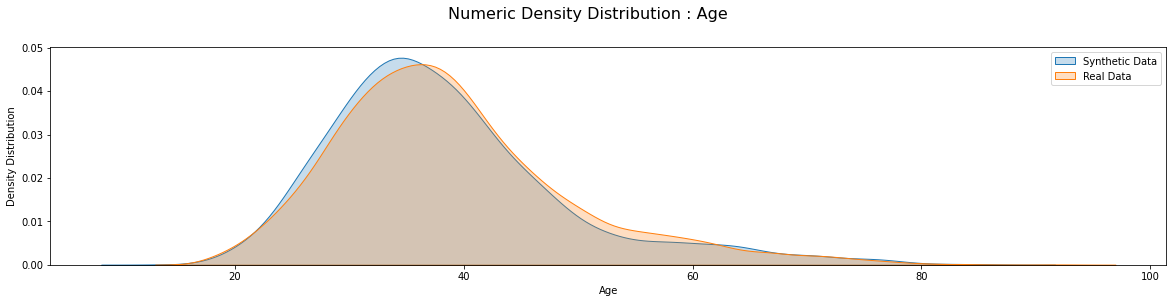

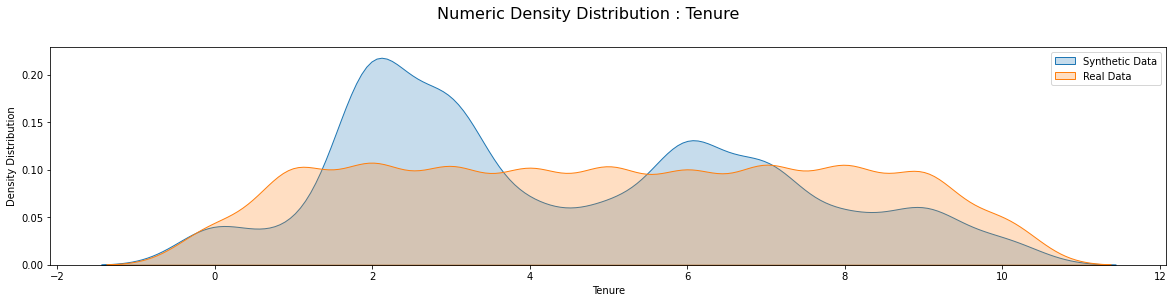

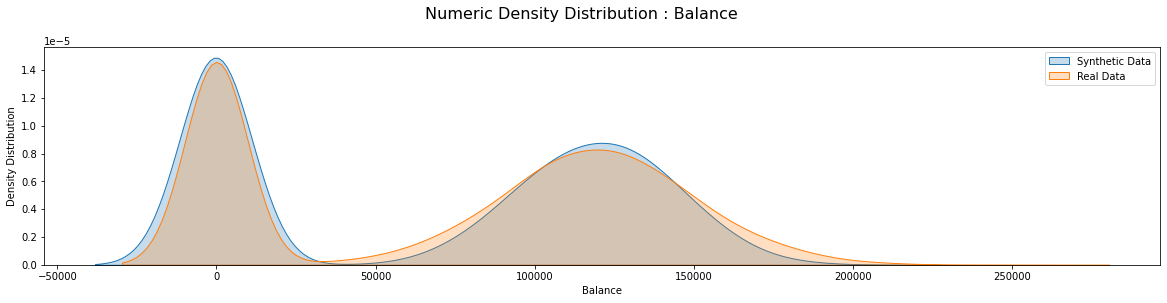

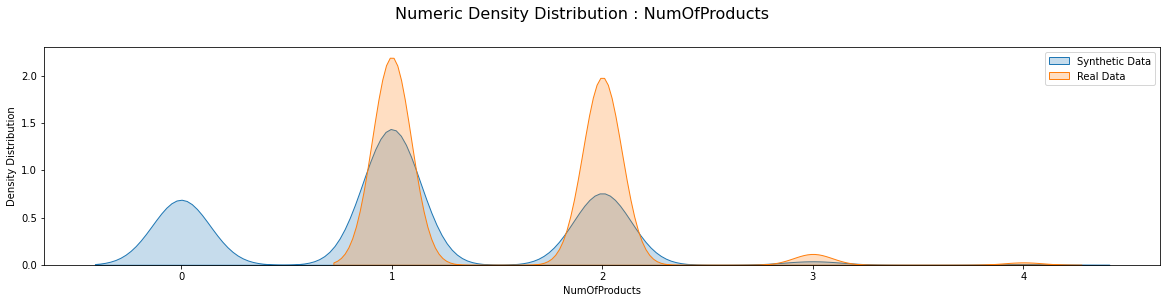

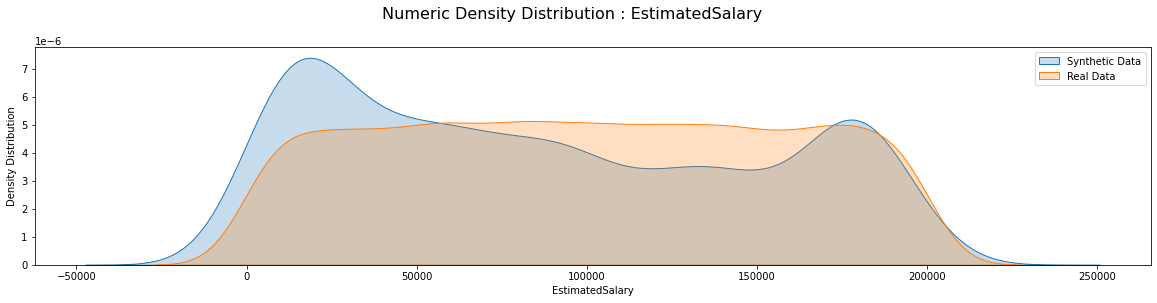

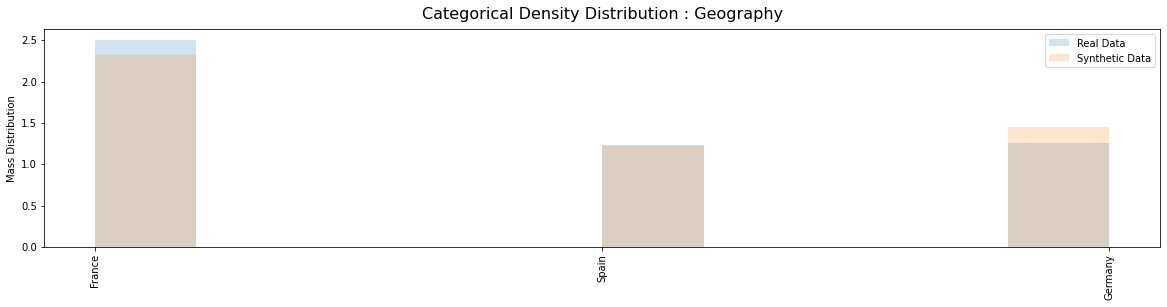

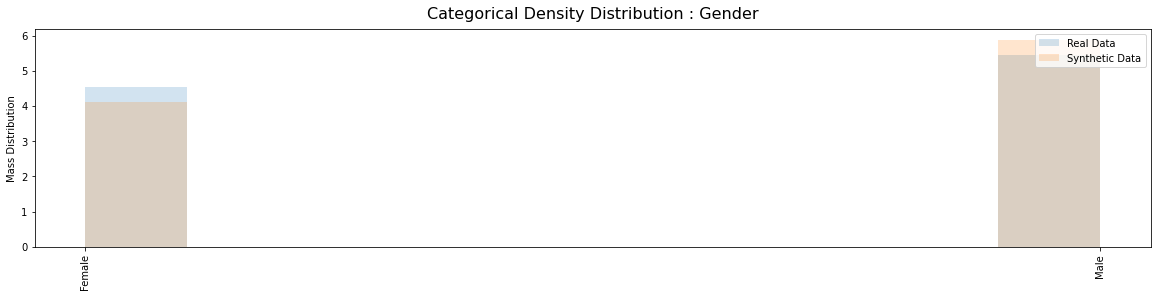

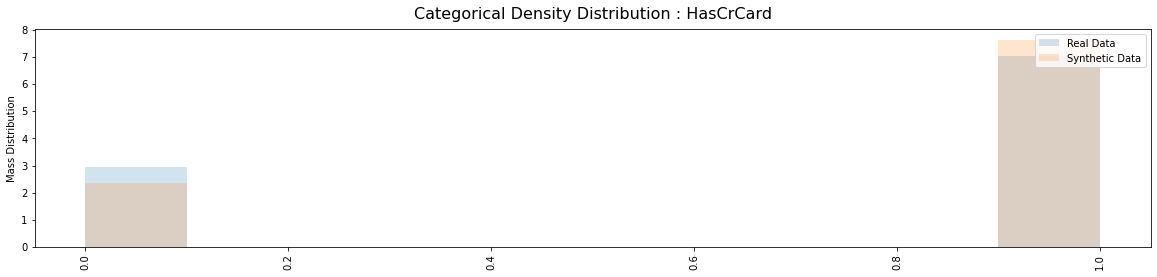

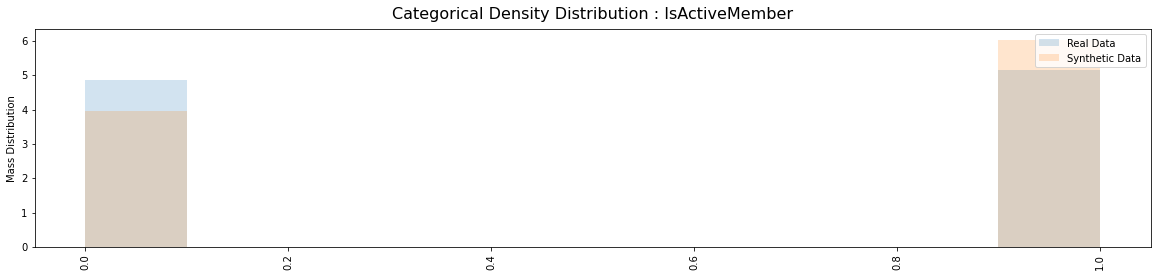

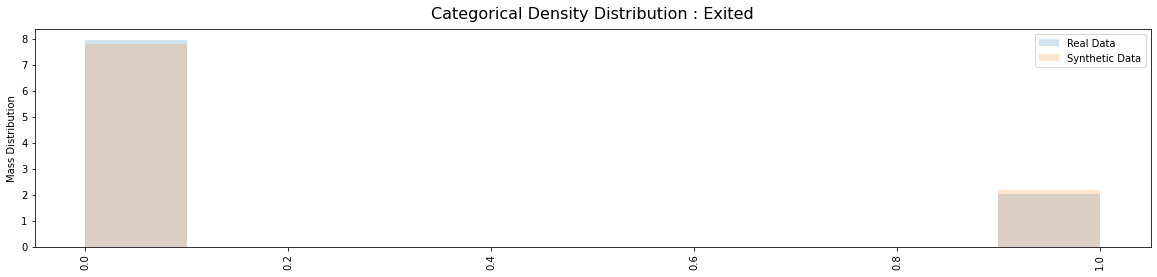

In [72]:
get_full_report(churn, sample,discrete_columns,numeric_features,target='Exited')

### Test churn ML Performance on standalone real data vs real+synthetic data

In [73]:
sample = sample[sample['Exited']==1].reset_index(drop=True)

In [74]:
real_data = churn
synthetic_data = sample
real_with_synthetic = pd.concat([real_data,synthetic_data],0).reset_index(drop=True) 

### Random Forest model on real vs real+synthetic data

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [76]:
churn.select_dtypes('object').columns

Index(['Geography', 'Gender'], dtype='object')

In [77]:
### Convert string cols to interets with Label Encoders

O_cols = churn.select_dtypes('object').columns

for o in O_cols:
    LE = LabelEncoder()
    real_data[o] = LE.fit_transform(real_data[o])
    real_with_synthetic[o]=LE.transform(real_with_synthetic[o])

In [78]:
real_X_train, real_X_test,real_Y_train,real_Y_test = train_test_split(real_data.drop(target,1),real_data[target],stratify=real_data[target])
combined_X_train, combined_X_test,combined_Y_train,combined_Y_test = train_test_split(real_with_synthetic.drop(target,1),real_with_synthetic[target],stratify=real_with_synthetic[target])

In [79]:
rf_real = RandomForestClassifier()
rf_real.fit(real_X_train,real_Y_train)
probs = rf_real.predict_proba(real_X_test)[:,1]

print(f'AUC Score with real only data:{roc_auc_score(real_Y_test,probs)}')

AUC Score with real only data:0.8581174223100219


In [80]:
rf_real = RandomForestClassifier()
rf_real.fit(combined_X_train,combined_Y_train)
probs = rf_real.predict_proba(combined_X_test)[:,1]

print(f'AUC Score with combined data:{roc_auc_score(combined_Y_test,probs)}')

AUC Score with combined data:0.8791177947824032


### Fin ###